#Analisis 4505 Embarazos - HTS

## Inicio

In [0]:
#Importamos las librerias necesarias

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#leemos el documento de gestantes, utilizamos encoding latin1 ya que utf-8 nos genera error

data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Datasets/cuarto trimeste 4505 2018 ok.csv", sep="|")

##Conociendo nuestro Dataset

In [0]:
#Número de columnas y registros
data.shape

(599790, 15)

In [0]:
#mostramos los elementos para ver si se cargo bien el documento 
#dataset completo original

data.head()

,fecha_nacimiento,sexo,etnia,ocupacion,nivel_educativo,gestacion,obesidad_desnutricion,victima_maltrato,victima_violencia_sexual,infecciones_trasmision_sexual,enfermedad_mental,peso_kg,talla_cm,planificacion_familiar_primera_vez,suministro_metodo_anticonceptivo
0,1987-04-05,M,6,9999,13,0,3,0,2,2,7,57,158,1800-01-01,21
1,1986-10-21,F,6,9999,13,2,3,0,2,2,7,63,162,1800-01-01,21
2,1987-03-29,F,6,9999,13,2,3,0,2,2,7,65,164,1800-01-01,21
3,1986-04-04,F,6,9999,13,2,3,0,2,2,7,62,158,1800-01-01,21
4,1987-02-11,M,6,9999,13,0,3,0,2,2,7,61,162,1800-01-01,21


In [0]:
# Vamos a hacer un resumen de los estadísticos básicos de las variables numéricas.
  
data.describe()

,etnia,ocupacion,nivel_educativo,gestacion,obesidad_desnutricion,victima_maltrato,victima_violencia_sexual,infecciones_trasmision_sexual,enfermedad_mental,peso_kg,talla_cm,suministro_metodo_anticonceptivo
count,599790.000000,599790.000000,599790.000000,599790.000000,599790.000000,599790.000000,599790.000000,599790.000000,599790.000000,599790.000000,599790.000000,599790.000000
mean,5.884896,9974.324250,8.899777,4.175445,12.950033,10.608836,12.253074,11.525709,15.579089,427.364056,483.887307,11.785565
std,0.696558,345.322055,5.246269,7.870871,9.027162,9.411216,9.470449,9.501321,6.838396,467.956104,422.323168,10.068487
min,1.000000,6.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,6.000000,0.000000
25%,6.000000,9998.000000,3.000000,0.000000,3.000000,3.000000,2.000000,2.000000,7.000000,41.000000,145.000000,0.000000
50%,6.000000,9999.000000,13.000000,0.000000,21.000000,3.000000,21.000000,21.000000,21.000000,68.000000,165.000000,21.000000
75%,6.000000,9999.000000,13.000000,2.000000,21.000000,21.000000,21.000000,21.000000,21.000000,999.000000,999.000000,21.000000
max,6.000000,9999.000000,13.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,999.000000,999.000000,21.000000


In [0]:
# Vamos a conocer el tipo de datos el cual es cada columna de la tabla

data.dtypes

fecha_nacimiento                      object
sexo                                  object
etnia                                  int64
ocupacion                              int64
nivel_educativo                        int64
gestacion                              int64
obesidad_desnutricion                  int64
victima_maltrato                       int64
victima_violencia_sexual               int64
infecciones_trasmision_sexual          int64
enfermedad_mental                      int64
peso_kg                                int64
talla_cm                               int64
planificacion_familiar_primera_vez    object
suministro_metodo_anticonceptivo       int64
dtype: object

##Mapeo de Datos

In [0]:
#Calcularemos la edad en base a la fecha de nacimiento

#Funcion para calcular la edad en base a 2018
def calcula_edad(cuando,anio):
    momento = cuando[:4]
    return anio - int(momento)

data['edad']=data.apply(lambda x: calcula_edad(x['fecha_nacimiento'],2018), axis=1);

In [0]:
data['edad'].describe()

count    599790.000000
mean         24.624930
std          21.075068
min           0.000000
25%           9.000000
50%          17.000000
75%          35.000000
max         113.000000
Name: edad, dtype: float64

In [0]:
#Mapeo de sexo
data.loc[data['sexo'] == 'M', 'sexoEncoded'] = 0 #hombre
data.loc[data['sexo'] == 'F', 'sexoEncoded'] = 1 #mujer

# Mapping edad en la que estan embarazadas
data.loc[ data['edad'] <= 17, 'edadEncoded']                        = int(0)
data.loc[(data['edad'] > 17) & (data['edad'] <= 26), 'edadEncoded'] = int(1)
data.loc[(data['edad'] > 26) & (data['edad'] <= 30), 'edadEncoded'] = int(2)
data.loc[(data['edad'] > 30) & (data['edad'] <= 40), 'edadEncoded'] = int(3)
data.loc[ data['edad'] > 40, 'edadEncoded'] = int(4)

#Mapeo de gestacion
data.loc[data['gestacion'] == 0, 'gestacionEncoded'] = int(0) #no
data.loc[data['gestacion'] == 1, 'gestacionEncoded'] = int(1) #si
data.loc[data['gestacion'] == 2, 'gestacionEncoded'] = int(0) #no
data.loc[data['gestacion'] == 21, 'gestacionEncoded'] = int(0) #no

#Mapeo de etnia
data.loc[ data['etnia'] <= 5, 'etniaEncoded']                        = int(1) #si pertenece a etnia
data.loc[(data['etnia'] > 5) & (data['etnia'] <= 6), 'etniaEncoded'] = int(0) #no pertenece a etnia

# Mapping codigo nivel educativo
data.loc[ data['nivel_educativo'] <= 2, 'educativoEncoded']                        = int(0) #prescolar y primaria
data.loc[(data['nivel_educativo'] > 2) & (data['nivel_educativo'] <= 6), 'educativoEncoded'] = int(1) #basica secundaria, media academica, media tecnica, normalista
data.loc[(data['nivel_educativo'] > 6) & (data['nivel_educativo'] <= 8), 'educativoEncoded'] = int(2) #tecnico profesional y tecnologo
data.loc[(data['nivel_educativo'] > 8) & (data['nivel_educativo'] <= 12), 'educativoEncoded'] = int(3) #profesional, especializacion, maestria y doctorado
data.loc[ data['nivel_educativo'] > 12, 'educativoEncoded'] = int(4) #ninguno

# Mapping obesidad
data.loc[data['obesidad_desnutricion'] == 3, 'obesidadEncoded'] = int(0) #no
data.loc[data['obesidad_desnutricion'] == 1, 'obesidadEncoded'] = int(1) #si obesidad
data.loc[data['obesidad_desnutricion'] == 2, 'obesidadEncoded'] = int(1) #si desnutricion
data.loc[data['obesidad_desnutricion'] == 21, 'obesidadEncoded'] = int(0) #no

# Mapping victima de maltrato
data.loc[data['victima_maltrato'] == 0, 'maltratoEncoded'] = int(0) #no
data.loc[data['victima_maltrato'] == 1, 'maltratoEncoded'] = int(1) #si es mujer victima de maltrato
data.loc[data['victima_maltrato'] == 2, 'maltratoEncoded'] = int(1) #si es menor victima de maltrato
data.loc[data['victima_maltrato'] == 3, 'maltratoEncoded'] = int(0) #no
data.loc[data['victima_maltrato'] == 21, 'maltratoEncoded'] = int(0) #no

# Mapping victima de violencia sexual
data.loc[data['victima_violencia_sexual'] == 2, 'violenciaSexualEncoded'] = int(0) #no
data.loc[data['victima_violencia_sexual'] == 1, 'violenciaSexualEncoded'] = int(1) #si
data.loc[data['victima_violencia_sexual'] == 21, 'violenciaSexualEncoded'] = int(0) #no riesgo no evaulado

#Mapping infecciones_trasmision_sexual
data.loc[data['infecciones_trasmision_sexual '] == 2, 'infeccionSexualEncoded'] = int(0) #no
data.loc[data['infecciones_trasmision_sexual '] == 1, 'infeccionSexualEncoded'] = int(1) #si
data.loc[data['infecciones_trasmision_sexual '] == 21, 'infeccionSexualEncoded'] = int(0) #no riesgo no evaulado

#Mapping enfermedad_mental
data.loc[ data['enfermedad_mental '] <= 6, 'enfermedadMentalEncoded']                        = int(1) # si enfermedad mental
data.loc[(data['enfermedad_mental '] > 6) & (data['enfermedad_mental '] <= 21), 'enfermedadMentalEncoded'] = int(0) #no

In [0]:
data.head()

,fecha_nacimiento,sexo,etnia,ocupacion,nivel_educativo,gestacion,obesidad_desnutricion,victima_maltrato,victima_violencia_sexual,infecciones_trasmision_sexual,enfermedad_mental,peso_kg,talla_cm,planificacion_familiar_primera_vez,suministro_metodo_anticonceptivo,edad,sexoEncoded,edadEncoded,gestacionEncoded,etniaEncoded,educativoEncoded,obesidadEncoded,maltratoEncoded,violenciaSexualEncoded,infeccionSexualEncoded,enfermedadMentalEncoded
0,1987-04-05,M,6,9999,13,0,3,0,2,2,7,57,158,1800-01-01,21,31,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,1986-10-21,F,6,9999,13,2,3,0,2,2,7,63,162,1800-01-01,21,32,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,1987-03-29,F,6,9999,13,2,3,0,2,2,7,65,164,1800-01-01,21,31,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,1986-04-04,F,6,9999,13,2,3,0,2,2,7,62,158,1800-01-01,21,32,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
4,1987-02-11,M,6,9999,13,0,3,0,2,2,7,61,162,1800-01-01,21,31,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


##Subcojunto de datos a utilizar para analisis de arbol de decisión

In [0]:
#Creamos un subconjunto con los datos necesarios originales del dataset principal
#Eliminamos columnas que no se tendran en cuenta para el analisis

subset = data[['sexoEncoded', 'edadEncoded', 'gestacionEncoded', 'etniaEncoded', 'educativoEncoded', 'obesidadEncoded', 'maltratoEncoded', 'violenciaSexualEncoded', 'infeccionSexualEncoded', 
               'enfermedadMentalEncoded', 'suministro_metodo_anticonceptivo', 'peso_kg', 'talla_cm']]
subset.head()

,sexoEncoded,edadEncoded,gestacionEncoded,etniaEncoded,educativoEncoded,obesidadEncoded,maltratoEncoded,violenciaSexualEncoded,infeccionSexualEncoded,enfermedadMentalEncoded,suministro_metodo_anticonceptivo,peso_kg,talla_cm
0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,57,158
1,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,63,162
2,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,65,164
3,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,62,158
4,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,61,162


In [0]:
# Vamos a conocer el tipo de datos el cual es cada columna de la tabla

subset.dtypes

sexoEncoded                         float64
edadEncoded                         float64
gestacionEncoded                    float64
etniaEncoded                        float64
educativoEncoded                    float64
obesidadEncoded                     float64
maltratoEncoded                     float64
violenciaSexualEncoded              float64
infeccionSexualEncoded              float64
enfermedadMentalEncoded             float64
suministro_metodo_anticonceptivo      int64
peso_kg                               int64
talla_cm                              int64
dtype: object

##Gráfica de correlación

In [0]:
df = pd.DataFrame({'a': subset['sexoEncoded']})
df['b'] = subset['edadEncoded']
df['c'] = subset['gestacionEncoded']
df['d'] = subset['etniaEncoded']
df['e'] = subset['educativoEncoded']
df['f'] = subset['obesidadEncoded']
df['g'] = subset['maltratoEncoded']
df['h'] = subset['violenciaSexualEncoded']
df['i'] = subset['infeccionSexualEncoded']
df['j'] = subset['enfermedadMentalEncoded']
df['k'] = subset['suministro_metodo_anticonceptivo']
df['l'] = subset['peso_kg']
df['m'] = subset['talla_cm']

df.corr()

,a,b,c,d,e,f,g,h,i,j,k,l,m
a,1.000000,0.112691,0.121551,-0.023350,-0.026674,0.011689,0.010481,0.009911,0.011210,-0.000797,0.056180,-0.035292,-0.034905
b,0.112691,1.000000,-0.005355,-0.009781,-0.005580,-0.039984,-0.001999,-0.004563,0.012799,0.030422,0.105844,0.086242,0.090271
c,0.121551,-0.005355,1.000000,0.005009,-0.022913,0.004606,0.005887,0.011114,0.044647,-0.004935,0.078831,-0.095574,-0.095435
d,-0.023350,-0.009781,0.005009,1.000000,-0.000369,-0.015181,-0.002370,-0.000841,-0.003748,0.000495,-0.052824,-0.069775,-0.070386
e,-0.026674,-0.005580,-0.022913,-0.000369,1.000000,-0.101673,-0.003708,-0.006641,-0.007230,-0.011124,-0.088430,0.086755,0.087782
f,0.011689,-0.039984,0.004606,-0.015181,-0.101673,1.000000,-0.000638,-0.000638,0.006639,0.013250,-0.108543,-0.200243,-0.204668
g,0.010481,-0.001999,0.005887,-0.002370,-0.003708,-0.000638,1.000000,0.402951,0.017652,0.022679,0.006069,-0.004162,-0.003690
h,0.009911,-0.004563,0.011114,-0.000841,-0.006641,-0.000638,0.402951,1.000000,0.012426,0.020989,0.002515,-0.008774,-0.008622
i,0.011210,0.012799,0.044647,-0.003748,-0.007230,0.006639,0.017652,0.012426,1.000000,0.017416,0.019382,-0.017141,-0.017155
j,-0.000797,0.030422,-0.004935,0.000495,-0.011124,0.013250,0.022679,0.020989,0.017416,1.000000,0.009030,-0.023232,-0.022594


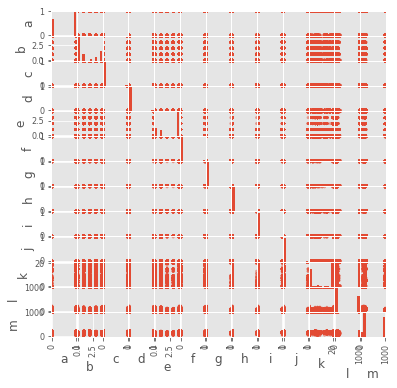

In [0]:
pd.plotting.scatter_matrix(df, figsize=(6, 6))
plt.show()

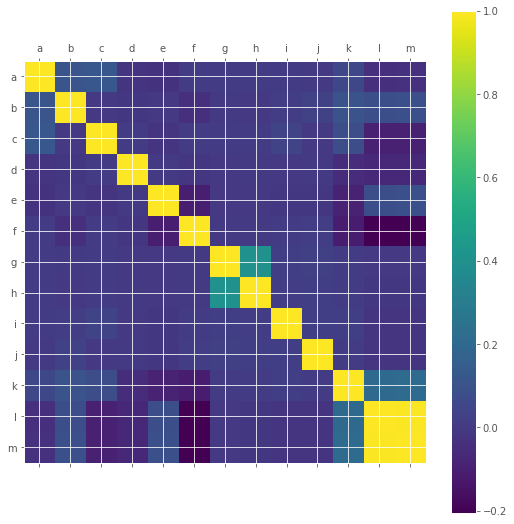

In [0]:
plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

In [0]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(subset))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:27.2})
    for train_fold, valid_fold in cv.split(subset):
        f_train = subset.loc[train_fold] 
        f_valid = subset.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['gestacionEncoded'], axis=1), 
                               y = f_train['gestacionEncoded']) 
        valid_acc = model.score(X = f_valid.drop(['gestacionEncoded'], axis=1), 
                                y = f_valid["gestacionEncoded"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.642555
         2          0.655503
         3          0.774526
         4          0.849451
         5          0.850021
         6          0.863647
         7          0.908678
         8          0.906381
         9          0.906424
        10          0.902384
        11          0.902578
        12          0.904128
        13          0.904285


##Arbol de decisión

In [0]:
subset.head()

,sexoEncoded,edadEncoded,gestacionEncoded,etniaEncoded,educativoEncoded,obesidadEncoded,maltratoEncoded,violenciaSexualEncoded,infeccionSexualEncoded,enfermedadMentalEncoded,suministro_metodo_anticonceptivo,peso_kg,talla_cm
0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,57,158
1,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,63,162
2,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,65,164
3,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,62,158
4,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,21,61,162


In [0]:
import seaborn as sns

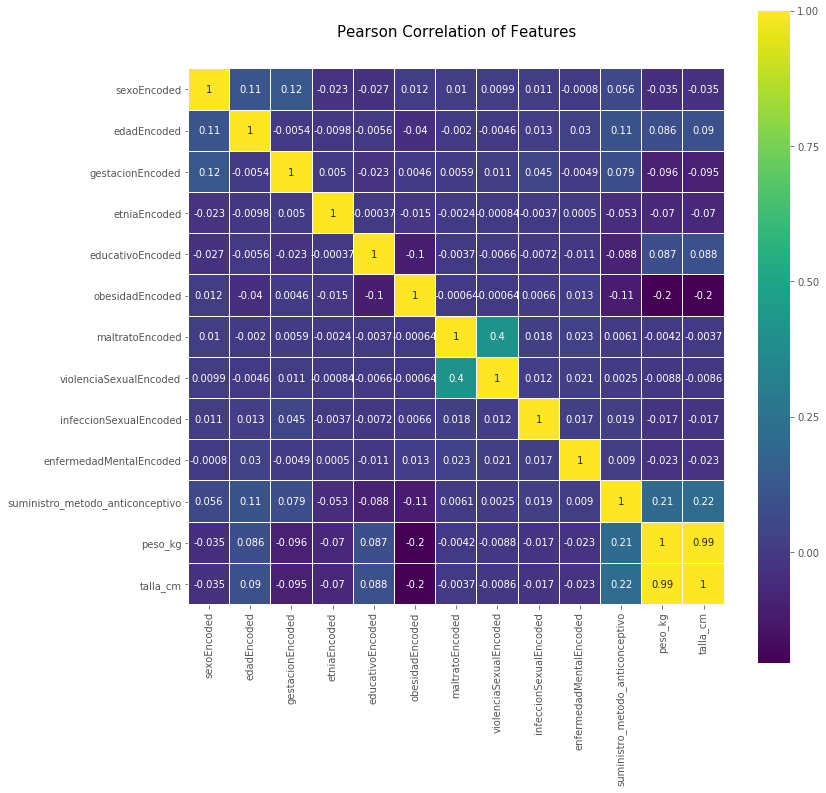

In [0]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(subset.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [0]:
subset[['sexoEncoded', 'gestacionEncoded']].groupby(['sexoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

gestacionEncoded                 
                        mean   count      sum
sexoEncoded                                  
0.0                 0.000000  245400      0.0
1.0                 0.035357  354390  12530.0

In [0]:
# Define function to calculate Gini Impurity
def get_gini_impurity(pregnant_count, total_count):
    pregnant_prob = pregnant_count/total_count
    not_pregnant_prob = (1 - pregnant_prob)
    random_observation_pregnant_prob = pregnant_prob
    random_observation_not_pregnant_prob = (1 - random_observation_pregnant_prob)
    mislabelling_pregnant_prob = not_pregnant_prob * random_observation_pregnant_prob
    mislabelling_not_pregnant_prob = pregnant_prob * random_observation_not_pregnant_prob
    gini_impurity = mislabelling_pregnant_prob + mislabelling_not_pregnant_prob
    return gini_impurity

In [0]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(12530, 599790)
gini_impurity_starting_node

0.04090845201623711